In [1]:
import pandas as pd
df_treatments = pd.read_csv("treatments.csv")
df_appointments = pd.read_csv("appointments.csv")

In [2]:
df_treatments.shape, df_appointments.shape

((200, 6), (200, 7))

# FIRST HYPOTHESIS
Doctors who initiate treatment faster (i.e., have a smaller gap between appointment_date and treatment_date) are more efficient and may contribute to better patient outcomes.

In [3]:
# create a new dataframe with the join of two dataframes on appointment_id
df_joined = pd.merge(df_treatments, df_appointments, on='appointment_id', how='inner')

In [4]:
df_joined.head()

,treatment_id,appointment_id,treatment_type,description,cost,treatment_date,patient_id,doctor_id,appointment_date,appointment_time,reason_for_visit,status
0,T001,A001,Chemotherapy,Basic screening,3941.97,2023-08-09,P034,D009,2023-08-09,15:15:00,Therapy,Scheduled
1,T002,A002,MRI,Advanced protocol,4158.44,2023-06-09,P032,D004,2023-06-09,14:30:00,Therapy,No-show
2,T003,A003,MRI,Standard procedure,3731.55,2023-06-28,P048,D004,2023-06-28,8:00:00,Consultation,Cancelled
3,T004,A004,MRI,Basic screening,4799.86,2023-09-01,P025,D006,2023-09-01,9:15:00,Consultation,Cancelled
4,T005,A005,ECG,Standard procedure,582.05,2023-07-06,P040,D003,2023-07-06,12:45:00,Emergency,No-show


In [5]:
# CALCULATE the time difference between "treatment_date" and "appointment_date" for every single treatment. Let's call this new metric "Time-to-Treat"
df_joined["treatment_date"] = pd.to_datetime(df_joined["treatment_date"])
df_joined["appointment_date"] = pd.to_datetime(df_joined["appointment_date"])
df_joined["Time-to-Treat"] = (df_joined["treatment_date"] - df_joined["appointment_date"]).dt.days
# Display the first few rows of the updated dataframe
df_joined.head()

,treatment_id,appointment_id,treatment_type,description,cost,treatment_date,patient_id,doctor_id,appointment_date,appointment_time,reason_for_visit,status,Time-to-Treat
0,T001,A001,Chemotherapy,Basic screening,3941.97,2023-08-09,P034,D009,2023-08-09,15:15:00,Therapy,Scheduled,0
1,T002,A002,MRI,Advanced protocol,4158.44,2023-06-09,P032,D004,2023-06-09,14:30:00,Therapy,No-show,0
2,T003,A003,MRI,Standard procedure,3731.55,2023-06-28,P048,D004,2023-06-28,8:00:00,Consultation,Cancelled,0
3,T004,A004,MRI,Basic screening,4799.86,2023-09-01,P025,D006,2023-09-01,9:15:00,Consultation,Cancelled,0
4,T005,A005,ECG,Standard procedure,582.05,2023-07-06,P040,D003,2023-07-06,12:45:00,Emergency,No-show,0


In [6]:
#show rows where Time-to-Treat is greater than 0 days
df_joined[df_joined["Time-to-Treat"] > 0].head()

,treatment_id,appointment_id,treatment_type,description,cost,treatment_date,patient_id,doctor_id,appointment_date,appointment_time,reason_for_visit,status,Time-to-Treat


In [7]:
# AGGREGATE the data to get the average "Time-to-Treat" for each doctor.
df_avg_time_to_treat = df_joined.groupby("doctor_id")["Time-to-Treat"].mean().reset_index()
df_avg_time_to_treat.columns = ["doctor_id", "avg_time_to_treat"]
# Display the average time to treat for each doctor
df_avg_time_to_treat.head()

,doctor_id,avg_time_to_treat
0,D001,0.0
1,D002,0.0
2,D003,0.0
3,D004,0.0
4,D005,0.0


# SECOND HYPOTHESIS
A doctor's efficiency is directly related to their patient throughput, meaning doctors who successfully manage more appointments (e.g., status = "Completed") in a month are higher performers.

In [8]:
# in df_appointments filter out the rows where status is "completed" and group by doctor_id
df_completed_appointments = df_appointments[df_appointments["status"] == "Completed"].groupby("doctor_id").size().reset_index(name='completed_count')
df_completed_appointments.head()

,doctor_id,completed_count
0,D001,6
1,D002,5
2,D003,6
3,D004,3
4,D005,4


In [ ]:
#calculathe average completed appointments per month for each doctor
df_appointments["appointment_date"] = pd.to_datetime(df_appointments["appointment_date"])
df_appointments["month"] = df_appointments["appointment_date"].dt.to_period("M")
df_avg_completed_per_month = df_appointments[df_appointments["status"] == "Completed"].groupby(["doctor_id", "month"]).size().reset_index(name="completed_count")
df_avg_completed_per_month = df_avg_completed_per_month.groupby("doctor_id")["completed_count"].mean().reset_index()
df_avg_completed_per_month.columns = ["doctor_id", "avg_completed_per_month"]
# Display the average completed appointments per month for each doctor
df_avg_completed_per_month.head()

,doctor_id,avg_completed_per_month
0,D001,1.2
1,D002,1.0
2,D003,1.2
3,D004,1.0
4,D005,1.0


In [21]:
#get all appointments for doctor D001 and status is "Completed"
df_doctor_D001 = df_appointments[(df_appointments["doctor_id"] == "D001") & (df_appointments["status"] == "Completed")]
# Display the first few rows of the filtered dataframe
df_doctor_D001


,appointment_id,patient_id,doctor_id,appointment_date,appointment_time,reason_for_visit,status,month
82,A083,P050,D001,2023-11-07,12:30:00,Emergency,Completed,2023-11
92,A093,P034,D001,2023-04-09,9:30:00,Follow-up,Completed,2023-04
113,A114,P018,D001,2023-08-08,9:00:00,Therapy,Completed,2023-08
120,A121,P037,D001,2023-04-07,15:00:00,Checkup,Completed,2023-04
132,A133,P048,D001,2023-03-23,14:30:00,Checkup,Completed,2023-03
198,A199,P017,D001,2023-05-01,12:45:00,Follow-up,Completed,2023-05


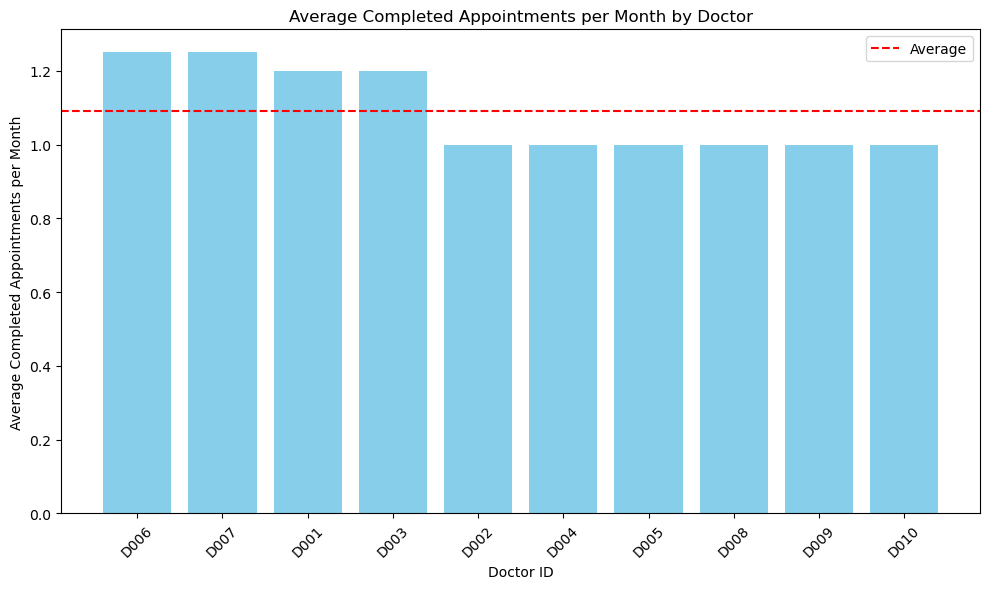

In [10]:
#show avg_completed_per_month in a bar chart
#sort df_avg_completed_per_month from highest to lowest
#add an average line
import matplotlib.pyplot as plt
df_avg_completed_per_month = df_avg_completed_per_month.sort_values(by="avg_completed_per_month", ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(df_avg_completed_per_month["doctor_id"].astype(str), df_avg_completed_per_month["avg_completed_per_month"], color='skyblue')
plt.axhline(df_avg_completed_per_month["avg_completed_per_month"].mean(), color='red', linestyle='--', label='Average')
plt.xlabel("Doctor ID")
plt.ylabel("Average Completed Appointments per Month")
plt.title("Average Completed Appointments per Month by Doctor")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# THIRD HYPOTHESIS
There is a positive correlation between a doctor's years of experience and their efficiency; more experienced doctors will have higher patient throughput and fewer cancelled appointments. 

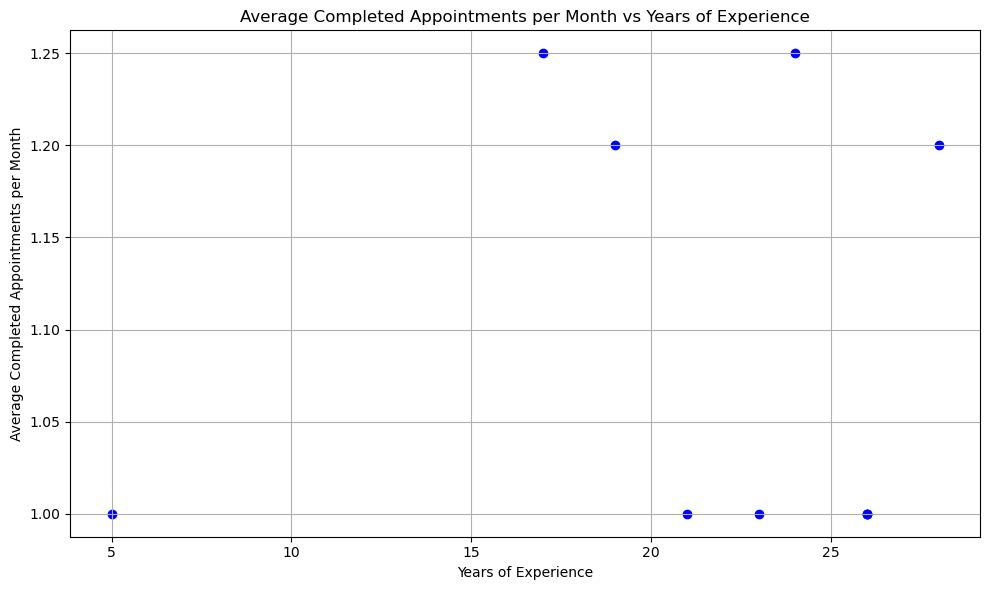

In [26]:
# create a new df the "years_experience" column from the doctors.csv file
df_doctors = pd.read_csv("doctors.csv")
df_doctors = df_doctors[["doctor_id", "years_experience"]]

# create a scatter plot of avg_completed_per_month vs years_experience and overlay a trend line
""" plt.figure(figsize=(10, 6))
plt.scatter(df_doctors["years_experience"], df_avg_completed_per_month["avg_completed_per_month"], color='blue', label='Data Points')
import numpy as np
z = np.polyfit(df_doctors["years_experience"],
               df_avg_completed_per_month["avg_completed_per_month"], 1)
p = np.poly1d(z)
plt.plot(df_avg_completed_per_month["avg_completed_per_month"], p(df_avg_completed_per_month["avg_completed_per_month"]), color='red', label='Trend Line')
plt.ylabel("Average Completed Appointments per Month")
plt.xlabel("Years of Experience")
plt.title("Average Completed Appointments per Month vs Years of Experience")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show() """

plt.figure(figsize=(10, 6))
plt.scatter(df_doctors["years_experience"],
            df_avg_completed_per_month["avg_completed_per_month"], color='blue')
plt.ylabel("Average Completed Appointments per Month")
plt.xlabel("Years of Experience")
plt.title("Average Completed Appointments per Month vs Years of Experience")
plt.grid()
plt.tight_layout()
plt.show()